# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [93]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
RateDogs = pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [5]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
imagePred = requests.get(url)
imagePred

<Response [200]>

In [9]:
with open('image-predictions.tsv', mode = 'wb') as file:
    file.write(imagePred.content)
imageDat = pd.read_csv('image-predictions.tsv', sep = '\t')
imageDat.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)


In [14]:
tweet_list = []
with open('tweet-json.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        parsed_json = json.loads(line)
        tweet_list.append({'tweet_id': parsed_json['id'],
                        'retweet_count': parsed_json['retweet_count'],
                        'favorite_count': parsed_json['favorite_count']})
        
tweet_json = pd.DataFrame(tweet_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

tweet_json.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [17]:
RateDogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [22]:
RateDogs.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [24]:
RateDogs['rating_denominator'].nunique()

18

In [18]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [31]:
tweet_json.nunique()

tweet_id          2354
retweet_count     1724
favorite_count    2007
dtype: int64

In [30]:
imageDat.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [27]:
imageDat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [29]:
imageDat.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

### Quality issues
1.Timestamp is a str when it should be a datetime.

2.in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, and retweeted_status_user_id are floats when they should be strings.

3.rating_denominator should always be 10 but we have multiple values.

4.in image table we have duplicate jpg_urls

5.We have entries that are not dogs where column_dog = false

6.Capitalization is all over the place in all the columns with dog names

7.We really should just keep the most accurate dog breed description instead of all three.

8.Tweet.json table has missing data.

### Tidiness issues
1. Doggo, Floofer, Pupper, and Puppo are all a type of dog and should be made into a single column with those as the values.

2.The tables contain duplicate information and should be made into one table so it's easier to read.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [32]:
# Make copies of original pieces of data
imageDat_backup = imageDat.copy()
tweet_json_backup = tweet_json.copy()
RateDogs_backup = RateDogs.copy()

### Issue #1: Timestamp is a str when it should be a datetime.

#### Define: use to_datetime

#### Code

In [34]:
RateDogs['timestamp'] = pd.to_datetime(RateDogs['timestamp'])

#### Test

In [35]:
RateDogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

### Issue #2: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, and retweeted_status_user_id are floats when they should be strings.

#### Define use astype(str) to change to a string

#### Code

In [38]:
RateDogs['in_reply_to_status_id'] = RateDogs['in_reply_to_status_id'].astype(str)
RateDogs['in_reply_to_user_id'] = RateDogs['in_reply_to_user_id'].astype(str)
RateDogs['retweeted_status_id'] = RateDogs['retweeted_status_id'].astype(str)
RateDogs['retweeted_status_user_id'] = RateDogs['retweeted_status_user_id'].astype(str)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       2356 non-null   object             
 2   in_reply_to_user_id         2356 non-null   object             
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         2356 non-null   object             
 7   retweeted_status_user_id    2356 non-null   object             
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

#### Test

In [39]:
RateDogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       2356 non-null   object             
 2   in_reply_to_user_id         2356 non-null   object             
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         2356 non-null   object             
 7   retweeted_status_user_id    2356 non-null   object             
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

Issue #3: rating_denominator should always be 10 but we have multiple values.

#### Define Set variable to a standard value

Code

In [40]:
RateDogs['rating_denominator'] = 10

Test

In [41]:
RateDogs['rating_denominator'].nunique()

1

Issue #4: in image table we have duplicate jpg_urls

Define use drop_duplicates to get rid of duplicate values.

Code

In [45]:
imageDat = imageDat.drop_duplicates(subset =['jpg_url'], keep=False)

Test

In [46]:
imageDat.nunique()

tweet_id    1943
jpg_url     1943
img_num        4
p1           373
p1_conf     1940
p1_dog         2
p2           398
p2_conf     1939
p2_dog         2
p3           404
p3_conf     1940
p3_dog         2
dtype: int64

Issue #5: We have entries that are not dogs where column_dog = false

Define: Drop values where dog = False

Code

In [48]:
print(imageDat.shape)

(1943, 12)


In [50]:
imageDat.query('p1_dog == False and p2_dog == False and p3_dog == False').tweet_id
drop = imageDat.query('p1_dog == False and p2_dog == False and p3_dog == False').tweet_id
imageDat = imageDat[~imageDat.tweet_id.isin(drop)]

Test

In [51]:
print(imageDat.shape)

(1631, 12)


Issue #6: Capitalization is all over the place in all the columns with dog names

Define: use str.lower() to make all colums lowercase

Code

In [52]:
imageDat['p1'] = imageDat['p1'].str.lower()
imageDat['p2'] = imageDat['p2'].str.lower()
imageDat['p3'] = imageDat['p3'].str.lower()

Test

In [53]:
imageDat.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


Issue #7: We really should just keep the most accurate dog breed description instead of all three.

define: use if else statements to only keep highest rated prediction

Code

In [65]:
breed = []
confidence = []

def image_clean(imageDat):
    if imageDat.p1_dog == True:
        breed.append(imageDat.p1)
        confidence.append(imageDat.p1_conf)
    elif imageDat.p2_dog == True:
        breed.append(imageDat.p2)
        confidence.append(imageDat.p2_conf)
    elif imageDat.p3_dog == True:
        breed.append(imageDat.p3)
        confidence.append(imageDat.p3_conf)
    else:
        breed.append('Unknown')
        confidence.append(0)

imageDat.apply(image_clean, axis=1)
        
imageDat['breed'] = breed
imageDat['confidence'] = confidence

Test

In [66]:
imageDat.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True,welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,german_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True,miniature_pinscher,0.560311


In [67]:
imageDat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1631 entries, 0 to 2073
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tweet_id    1631 non-null   int64  
 1   jpg_url     1631 non-null   object 
 2   img_num     1631 non-null   int64  
 3   p1          1631 non-null   object 
 4   p1_conf     1631 non-null   float64
 5   p1_dog      1631 non-null   bool   
 6   p2          1631 non-null   object 
 7   p2_conf     1631 non-null   float64
 8   p2_dog      1631 non-null   bool   
 9   p3          1631 non-null   object 
 10  p3_conf     1631 non-null   float64
 11  p3_dog      1631 non-null   bool   
 12  breed       1631 non-null   object 
 13  confidence  1631 non-null   float64
dtypes: bool(3), float64(4), int64(2), object(5)
memory usage: 157.7+ KB


Issue #8: Tweet.json table has missing data

Define: Probably due to data source issues.

Tidiness #1: Doggo, Floofer, Pupper, and Puppo are all a type of dog and should be made into a single column with those as the values.

Define: Use if else to create new dog_type column

Code

In [77]:
dog_type = []

def dogclean(RateDogs):
    if RateDogs.doggo == "doggo":
        dog_type.append(RateDogs.doggo)
    elif RateDogs.floofer == "floofer":
        dog_type.append(RateDogs.floofer)
    elif RateDogs.pupper == "pupper":
        dog_type.append(RateDogs.pupper)
    elif RateDogs.puppo == "puppo":
        dog_type.append(RateDogs.puppo)
    else:
        dog_type.append("None")

        
RateDogs.apply(dogclean, axis=1)
        
RateDogs['dog_type'] = dog_type

Test

In [78]:
RateDogs.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_type
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,None
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,nan,nan,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,None
2,891815181378084864,nan,nan,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,None
3,891689557279858688,nan,nan,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,None
4,891327558926688256,nan,nan,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,nan,nan,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,None


In [79]:
RateDogs['dog_type'].unique()

array(['None', 'doggo', 'puppo', 'pupper', 'floofer'], dtype=object)

Tidiness #2: The tables contain duplicate information and should be made into one table so it's easier to read.

Define: Clean and join tables

Code

In [81]:
imageDat = imageDat.drop(['img_num','p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'],axis=1)

In [82]:
imageDat.head()

,tweet_id,jpg_url,breed,confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,german_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311


In [83]:
join1 = pd.merge(RateDogs, imageDat,on = ['tweet_id'], how = 'left')

In [84]:
join1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,doggo,floofer,pupper,puppo,dog_type,jpg_url,breed,confidence
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643...,...,10,Phineas,None,None,None,None,None,NaN,NaN,NaN
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,nan,nan,NaN,https://twitter.com/dog_rates/status/892177421...,...,10,Tilly,None,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,chihuahua,0.323581
2,891815181378084864,nan,nan,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181...,...,10,Archie,None,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,chihuahua,0.716012
3,891689557279858688,nan,nan,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557...,...,10,Darla,None,None,None,None,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,labrador_retriever,0.168086
4,891327558926688256,nan,nan,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,nan,nan,NaN,https://twitter.com/dog_rates/status/891327558...,...,10,Franklin,None,None,None,None,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712


In [85]:
combined_data = pd.merge(join1, tweet_json,on = ['tweet_id'], how = 'left')

Test

In [86]:
combined_data.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,doggo,floofer,pupper,puppo,dog_type,jpg_url,breed,confidence,retweet_count,favorite_count
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643...,...,None,None,None,None,None,NaN,NaN,NaN,8853.0,39467.0
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,nan,nan,NaN,https://twitter.com/dog_rates/status/892177421...,...,None,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,chihuahua,0.323581,6514.0,33819.0
2,891815181378084864,nan,nan,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181...,...,None,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,chihuahua,0.716012,4328.0,25461.0
3,891689557279858688,nan,nan,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557...,...,None,None,None,None,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,labrador_retriever,0.168086,8964.0,42908.0
4,891327558926688256,nan,nan,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,nan,nan,NaN,https://twitter.com/dog_rates/status/891327558...,...,None,None,None,None,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,9774.0,41048.0


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [87]:
combined_data.to_csv('twitter_archive_master.csv')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### Insights:
1.The most common dog description is Pupper, though most have no description

2. The most common breeds are Retrievers

3. The average retweet count is 3165

1. The most common dog description

In [88]:
combined_data.dog_type.value_counts(normalize=True)

None       0.838710
pupper     0.103990
doggo      0.041171
puppo      0.012309
floofer    0.003820
Name: dog_type, dtype: float64

2. The most common breeds

In [89]:
combined_data.breed.value_counts(normalize=True)

golden_retriever      0.087676
labrador_retriever    0.063151
pembroke              0.057633
chihuahua             0.053342
pug                   0.037400
                        ...   
scotch_terrier        0.000613
entlebucher           0.000613
japanese_spaniel      0.000613
standard_schnauzer    0.000613
irish_wolfhound       0.000613
Name: breed, Length: 113, dtype: float64

3. Average Retweet

In [91]:
meantweet = combined_data['retweet_count'].mean()

print(meantweet)

3164.7973661852166


### Visualization

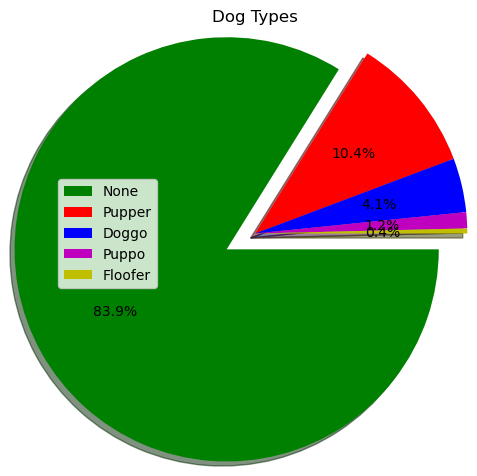

In [97]:
values = combined_data.dog_type.value_counts(normalize=True)
labels = ['None', 'Pupper', 'Doggo', 'Puppo', 'Floofer']
colors = ['g', 'r', 'b' ,'m', 'y']
explode = (0.2, 0, 0, 0, 0)

plt.pie(values, colors=colors, explode=explode, autopct='%1.1f%%', radius = 1.3, shadow=True, counterclock=False)
plt.legend(labels, loc=0)
plt.title('Dog Types')
plt.tight_layout()